<a href="https://colab.research.google.com/github/DineshJoshi2/Hydrological-Residual-Error-Modelling/blob/main/GRU_ONLY_for_3_Year_Training_and_3_year_testing_Data_(HYDROLOGICAL_RESIDUAL_ERROR_MODELLING).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# for reproducibility of the code
import os
os.environ["PYTHONHASHSEED"] = "0"
import numpy as np
import random as rn
import tensorflow as tf
# setting the seed for numpy generated random numbers
np.random.seed(73)
# setting the seed for python random number
rn.seed(723)
# setting the seed for tensorflow random number
tf.random.set_seed(1)

In [ ]:
# importing necessary libraries
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection import GridSearchCV


In [ ]:
# loading data set
df= pd.read_csv("/content/drive/MyDrive/Data/FourYearResidualErrorModelling.csv")
df=df[365:].reset_index(drop=True)

In [ ]:
# Retriving the necessary columns from the datasets.
 df=df[['Temperature (Deg C)', 'Precipitation (mm)',
       'Precipitation0816 (mm)', 'Temperature0816 (Deg C)', 'Observed Discharge (m3/s)']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [ ]:
# extrating the vaules from the data frame
values = df.values
values
# change all datatype to float
values = values.astype('float32')

In [ ]:
# normalization all features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
#converting the data into 3D array
l=[]
for i in range(len(df)-365):
    l.append(scaled[i:366+i,:])
Data=np.array(l)

In [ ]:
# checking the shape of the data
Data.shape

(2192, 366, 5)

In [ ]:
## test and train data
X=Data[:,:,:-1]
y=Data[:,-1,-1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, shuffle =False)
#one year Train size 0.833
# three year Train size 0.50

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1096, 366, 4)
(1096, 366, 4)
(1096,)
(1096,)


In [ ]:
# Useful functions to undo normalization later
def inv_yhat(yhat):
  yhat=[i[0] for i in yhat]
  A=np.zeros((len(yhat),5))
  A[:,0]=yhat
  A[:,1]=yhat
  A[:,2]=yhat
  A[:,3]=yhat
  A[:,4]=yhat
  inv_yhat= scaler.inverse_transform(A)
  inv_yhat = [i[-1] for i in inv_yhat]
  return inv_yhat
def inv_y(y):
  A=np.zeros((len(y),5))
  A[:,0]=y
  A[:,1]=y
  A[:,2]=y
  A[:,3]=y
  A[:,4]=y
  inv_y= scaler.inverse_transform(A)
  inv_y = [i[-1] for i in inv_y]
  return inv_y

In [ ]:
#import scikeras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras import optimizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection import GridSearchCV
#from scikeras.wrappers import KerasRegressor

In [ ]:
# Defining Some model parameters
epochs=1000
learning_rate1 = 0.01
#decay_rate = (learning_rate1*32)/epochs
decay_rate = (learning_rate1*128)/epochs

In [ ]:
# for reproducibility of the code
import os
os.environ["PYTHONHASHSEED"] = "0"
import numpy as np
import random as rn
import tensorflow as tf
# setting the seed for numpy generated random numbers
np.random.seed(73)
# setting the seed for python random number
rn.seed(723)
# setting the seed for tensorflow random number
tf.random.set_seed(1)

In [ ]:
# Building The Main Model
model = Sequential()
model.add(GRU(128,kernel_initializer="GlorotUniform",return_sequences=False,input_shape=(X_train.shape[1], X_train.shape[2]))) # main model
model.add(Dense(1))
Adam=tf.keras.optimizers.Adam(learning_rate = learning_rate1, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss="mae", optimizer=Adam, metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger,LearningRateScheduler

#ModelCheckpoint callback saves a model at some interval.
filepath="saved_models/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience= 100,verbose=1,restore_best_weights=True)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger("/content/drive/MyDrive/Data/LSTMlogs.csv", separator=',', append=False)

#learning rate decay
def exp_decay(epoch):
  lrate = learning_rate1 * np.exp(-decay_rate*epoch)
  return lrate

# learning schedule callback
lr_rate = LearningRateScheduler(exp_decay)

callbacks_list = [early_stop]

In [ ]:
# Training The Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs =epochs ,callbacks=callbacks_list, batch_size=len(X_train), verbose = 2, shuffle = True)

Epoch 1/1000
1/1 - 2s - loss: 0.2504 - mean_absolute_error: 0.2504 - val_loss: 0.5889 - val_mean_absolute_error: 0.5889 - 2s/epoch - 2s/step
Epoch 2/1000
1/1 - 0s - loss: 0.6462 - mean_absolute_error: 0.6462 - val_loss: 0.2320 - val_mean_absolute_error: 0.2320 - 215ms/epoch - 215ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.2504 - mean_absolute_error: 0.2504 - val_loss: 0.1338 - val_mean_absolute_error: 0.1338 - 188ms/epoch - 188ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.1052 - mean_absolute_error: 0.1052 - val_loss: 0.2530 - val_mean_absolute_error: 0.2530 - 146ms/epoch - 146ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.2184 - mean_absolute_error: 0.2184 - val_loss: 0.1999 - val_mean_absolute_error: 0.1999 - 172ms/epoch - 172ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.1642 - mean_absolute_error: 0.1642 - val_loss: 0.1327 - val_mean_absolute_error: 0.1327 - 174ms/epoch - 174ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.1037 - mean_absolute_error: 0.1037 - val_loss: 0.1448 - val_mean_absolute_error: 0.1448 - 14

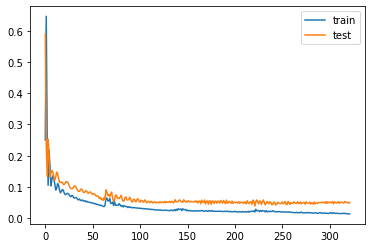

In [ ]:
# Loss Curve
import matplotlib.pyplot as plt
from matplotlib import pyplot
pyplot.plot(history.history['loss'][:], label='train')
pyplot.plot(history.history['val_loss'][:], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# prediction
yhat_test = model.predict(X_test)
yhat_train = model.predict(X_train)

35/35 [==============================] - 0s 6ms/step


In [ ]:
# Defining Function for Nash-Sutcliffe
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))

In [ ]:
#Evaluating the perfomance of the model for Training data set and Testing data set using Nash-Sutcliffe
inv_yhat_train = inv_yhat(yhat_train)
inv_yhat_test = inv_yhat(yhat_test)
inv_y_train = inv_y(y_train)
inv_y_test = inv_y(y_test)
print("train",nse(np.array(inv_yhat_train),np.array(inv_y_train)))
print("test",nse(np.array(inv_yhat_test),np.array(inv_y_test)))

train 0.9197398552770858
test 0.8743171011439392


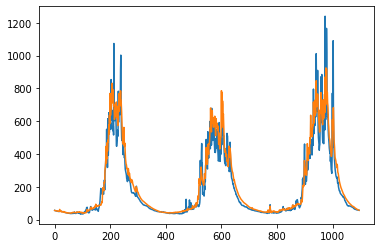

In [ ]:
# Train Plot
import matplotlib.pyplot as plt
plt.plot(inv_y_train[:])
plt.plot(inv_yhat_train[:])

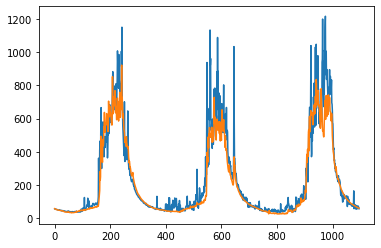

In [ ]:
# Test plot
import matplotlib.pyplot as plt
plt.plot(inv_y_test[:])
plt.plot(inv_yhat_test[:])

In [ ]:
import plotly.express as px
def reg_test_discharge_fig(inv_yhat_test,inv_y_test):
    reg_test_discharge_fig = px.scatter( x=inv_yhat_test, y=inv_y_test,
                                        trendline="ols",
                                        template = 'plotly_dark',
                                        title='Regression Plot between Observed and Simulated River Discharge')
    #reg_test_discharge_fig.update_layout(autosize=False,width=500,height=500)
    return reg_test_discharge_fig
reg_test_discharge_fig(inv_yhat_test,inv_y_test)